# Comentarios para José

* No saqué el return del update que me dijiste
* Todos los comentarios los hice en función de test con ruido, asi que si quieres sacar los graficos de test sin ruido no pasa nada.
* Para intentar que el RLS se parezca al NLMS usé 100 bs, pero podemos usar menos. xd 
* En ninguno de los filtros hice comentarios sobre el L. Creo que se deberia poner algo.
* Creo que falta profundizar, pero son las 4:20, y me dió sueño xd. Mañana en la mañana sigo.

### Instrucciones generales <a class="tocSkip"></a>

1. Forme un grupo de **máximo dos estudiantes**
1. Versione su trabajo usando un **repositorio <font color="red">privado</font> de github**. Agregue a su compañero y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas si la tarea no está en github. No se evaluarán tareas que no estén en github.
1. Se evaluará el **resultado, la profundidad de su análisis y la calidad/orden de sus códigos** en base al último commit antes de la fecha y hora de entrega". Se bonificará a quienes muestren un método de trabajo incremental y ordenado según el histórico de *commits*
1. Sean honestos, ríganse por el [código de ética de la ACM](https://www.acm.org/about-acm/code-of-ethics-in-spanish)



# Tarea 3: Predicción de una serie de tiempo caótica

En esta tarea se pide entrenar y evaluar un predictor para el sistema no-lineal [Mackey-Glass](https://en.wikipedia.org/wiki/Mackey-Glass_equations)

Esta serie de tiempo se obtiene de la solución de la siguiente ecuación diferencial

$$
\frac{dy}{dt} = \beta \frac{ y(t-\tau)}{1 + y(t-\tau)^{n}} - \gamma y(t),
$$

donde el parámetro $\tau$ controla el comportamiento dinámico de la serie de tiempo 

En esta tarea nos limitaremos en estudiar el caso con $n=10$, $\gamma = 0.1$ y $\beta = 0.2$

El valor del parámetro $\tau$ modifica el comportamiento dinámico del sistema, en particular se tiene que

- $\tau = 17$ el sistema tiene un comportamiento debilmente caótico
- $\tau = 30$ el sistema tiene un comportamiento fuertemente caótico

La ecuación de diferencial anterior fue propuesta por Michael Mackey and Leon Glass en 1977 como modelo para procesos fisiológicos asociados a la [homeostasis](https://es.wikipedia.org/wiki/Homeostasis)

El código adjunto a esta tarea genera la serie de tiempo en función 

Se generan 1000 muestras de la serie de tiempo. Use los primeros 500 puntos para entrenar, los siguientes 250 puntos para calibrar los hiperparámetros y los últimos 250 para evaluar y comparar los filtros

<IPython.core.display.Javascript object>


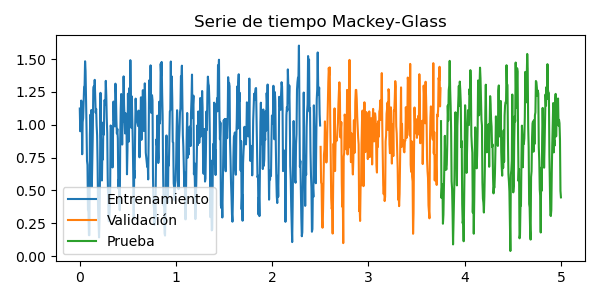

In [955]:
import numpy as np
%matplotlib notebook
import matplotlib.pylab as plt
from mackey import MackeyGlass

# Puede calcular el error medio cuadrático normalizado usando:
NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

# Gráfico
(t_train, y_train), (t_valid, y_valid), (t_test, y_test, y_real) = MackeyGlass(tau=30.)
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.plot(t_train, y_train, label='Entrenamiento')
ax.plot(t_valid, y_valid, label='Validación')
ax.plot(t_test, y_test, label='Prueba')
ax.set_title('Serie de tiempo Mackey-Glass');
ax.legend();


## (45%) Predicción con algoritmo LMS


### Describa en detalle el algoritmo LMS e implemente un predictor a un paso basado en el algoritmo LMS normalizado

Es un algoritmo utilizado en filtros adaptativos para encontrar los coeficientes del filtro que permiten obtener el valor minimo esperado del cuadrado de la señal de error  (diferencia entre la señal deseada y la señal producida por el filtro). 

El algoritmo está compuesto por 2 procesos:

1. **Proceso de filtrado**: Se realiza el calculo de la salida y la generación del error comparado con la salida.

2. **Proceso adaptativo**: Se realiza el ajuste de los coeficientes del filtro de forma automatica conforme a la estimación del error

Por otra parte, este algoritmo es una extension del filtro de Wiener, pero para los casos no estacionarios, por lo Su solucion converge a la solucion del filtro de Wiener

Las correcciones sucesivas del vector de pesos convergen al valor minimo del error medio cuadratico (si la tasa de aprendizaje se encuentra en un determinado rango de valores).


En la vesion normalizada (NLMS) se incorpora un temrino adicional a la regla iterativa que pondera el delta de los pesos por la varianza del vector u?.

**Funcionamiento del algoritmo LMS:**

- se calcula la salida y(n) a partir de la entrada x(n) y el vector de pesos w
- se determina el error (cuadratico instantaneo) e(n) entre la salida deseada d(n) e y(n)
- se actualizan los pesos utilizando la regla de Widrow-Hoff




In [956]:
class Filtro_NLMS:
    
    def __init__(self, L, mu, delta=1e-6, winit=None):
        self.L = L
        self.w = np.zeros(shape=(L+1, ))
        self.mu = mu
        self.delta = delta
        
    def update(self, un, dn):
        # Asumiendo que un = [u[n], u[n-1], ..., u[n-L]]
        unorm = np.dot(un, un) + self.delta
        yn = np.dot(self.w, un)
        self.w += 2*self.mu*(dn - yn)*(un/unorm)
        return yn
    
    def predict(self, un):
        return np.dot(self.w, un)

### Considere el caso 𝜏=17. Entrene su predictor en el conjunto de entrenamiento y encuentre la combinación de parámetros 𝜇 y 𝐿 que minimiza el NMSE en el conjunto de validación. Se recomienda realizar un barrido logarítmo para 𝜇. Para 𝐿 pruebe al menos los siguientes valores [5, 10, 20, 30]. Comente sobre lo que observa.

In [957]:
def train_NLMS(tau=17, L=None, mu=None):
    (t_train, y_train), (t_valid, y_valid), (t_test, y_test, y_real) = MackeyGlass(tau=tau)
    if L is not None:
        Ls = [L]
    else:
        #Ls = [5, 10, 20, 30]
        Ls = [3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50]
    
    if mu is not None:
        mus = [mu]
    else:
        mus = np.logspace(-4, 0, num=20)
    
    best_nmse = np.inf
    for L in Ls:
        for mu in (mus):
            myfilter = Filtro_NLMS(L=L, mu=mu)
            #entrenar
            for k in range(L+1, len(y_train)):
                myfilter.update(y_train[k-L-1:k][::-1], y_train[k])

            u_pred = np.zeros(shape=(len(y_valid)))
            for k in range(L+1, len(y_valid)):
                u_pred[k] = myfilter.predict(y_valid[k-L-1:k][::-1])

            nmse = NMSE(y_valid, u_pred)
            if (nmse < best_nmse):
                best_filter = myfilter
                best_nmse = nmse
                best_mu = mu
                best_L = L
                
    print(f"Best NMSE : {best_nmse}\nL {best_L} , mu : {best_mu}")
    return best_filter, best_L, best_mu



def predict_NLMS(best_L, y_test, myfilter):
    y_pred = np.zeros(shape=(len(y_test)))
    for k in range(best_L+1, len(y_test)):
        y_pred[k] = myfilter.predict(y_test[k-best_L-1:k][::-1])
    return y_pred


In [958]:
tau = 17
myfilter, best_L, best_mu = train_NLMS(tau=tau)

Best NMSE : 228.9522991558531
L 8 , mu : 0.08858667904100823


In [959]:
y_pred_NLMS17 = predict_NLMS(best_L, y_test, myfilter)

<IPython.core.display.Javascript object>


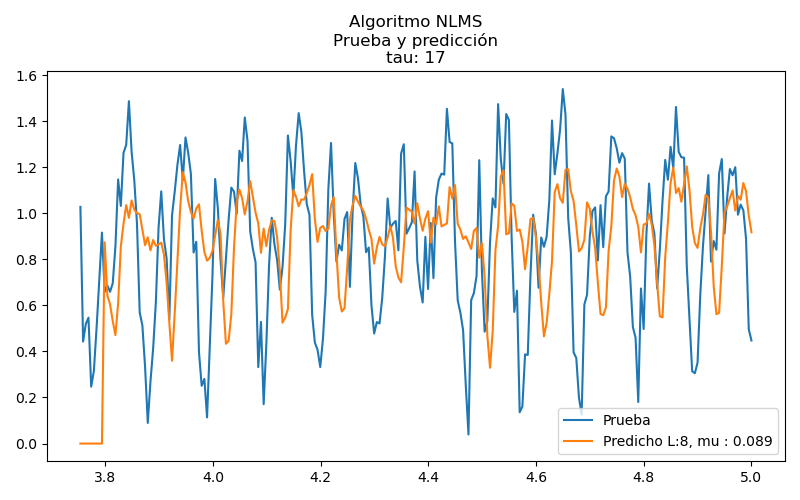

In [960]:
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.plot(t_test, y_test, label='Prueba')
ax.plot(t_test, y_pred_NLMS17, label=f'Predicho L:{best_L}, mu : {best_mu:.3f}')
ax.legend()
ax.set_title(f'Algoritmo NLMS\nPrueba y predicción\ntau: {tau}');



### Repita el paso anterior para el caso $\tau = 30$ 

In [962]:
tau = 30
myfilter, best_L, best_mu = train_NLMS(tau=tau)

Best NMSE : 183.14739820095443
L 3 , mu : 0.08858667904100823


In [963]:
y_pred_NLMS30 = predict_NLMS(best_L, y_test, myfilter)

<IPython.core.display.Javascript object>


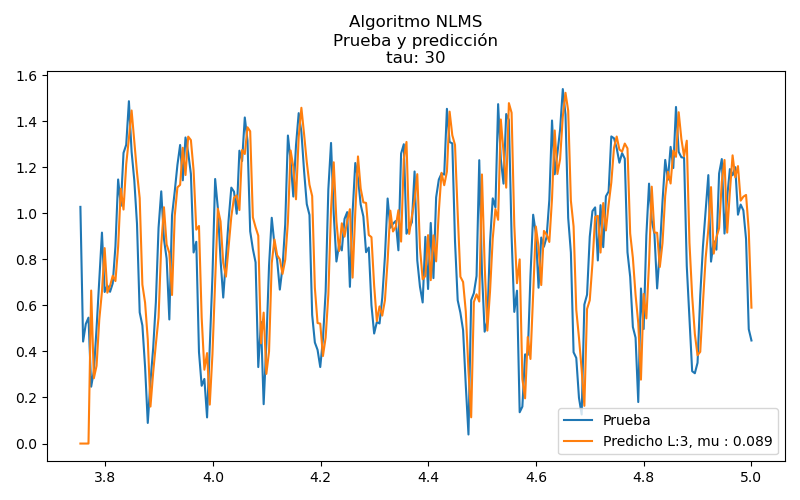

In [964]:
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.plot(t_test, y_test, label='Prueba')
ax.plot(t_test, y_pred_NLMS30, label=f'Predicho L:{best_L}, mu : {best_mu:.3f}')
ax.legend()
ax.set_title(f'Algoritmo NLMS\nPrueba y predicción\ntau: {tau}');

### Muestre también los residuos. 


<IPython.core.display.Javascript object>


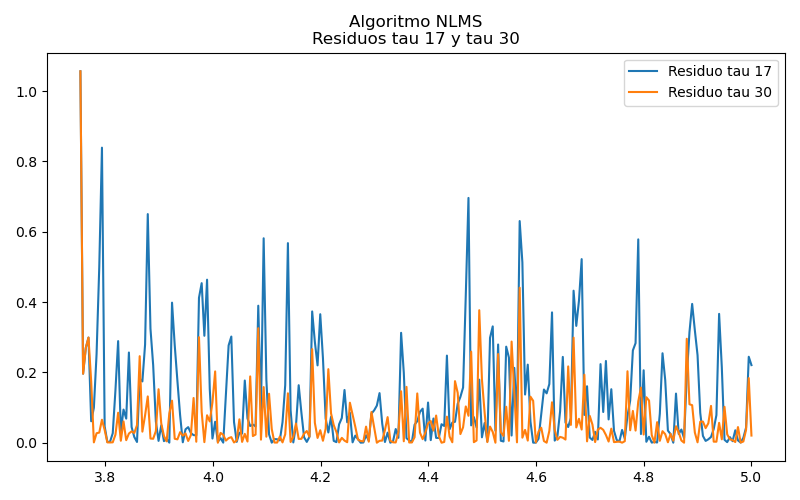

In [966]:
residuo_tau17 = (y_test - y_pred_NLMS17)**2 
residuo_tau30 = (y_test - y_pred_NLMS30)**2 

fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.plot(t_test, residuo_tau17, label='Residuo tau 17')
ax.plot(t_test, residuo_tau30, label='Residuo tau 30')
ax.set_title(f'Algoritmo NLMS\nResiduos tau 17 y tau 30');
ax.legend()

#### Discuta y analice sus resultados

El valor de aprendizaje optimo para ambas serie de tiempo Mackey-Glass es de tau es 0.089.

Podemos apreciar claramente como el algoritmo NLMS para la serie de tiempo Mackey-Glass con tau 17, funciona de muy buena manera, eliminadno gran cantidad de ruido, por el contrario a la serie de tiempo Mackey-Glass con tau 30, la cual al ser más caotica es más complejo poder realizar un filtrado más preciso sobreajustandose al ruido de la serie. 

Cabe destacar que es posible que tau 17 está eliminando parte de la serie de tiempo debido a que no es capaz de diferenciar entre ruido y la señal original.


Esto lo podemos clarificar al graficar sus residuos, donde podemos ver que la serie de tiempo Mackey-Glass con tau 17 posee difrencias bastante más notorias que Mackey-Glass con tau 30 con la serie de tiempo con ruido.

Por lo que podemos concluir que utilizando un algoritmo NLMS es posible realizar un filtrado correcto si la señal no es caotica y si este fuera el caso, la serie retornada será sobreajustada al ruido.

## (45%) Predicción con algoritmo RLS



### 1. Describa en detalle el algoritmo RLS e implemente un predictor a un paso basado en el algoritmo RLS. Resalte las diferencias con el algoritmo LMS


El algoritmo  RLS (minimos cuadrados recursivos) es un método online que minimiza el error histórico, es decir la suma de error es desde la muestra inicial hasta la actual 

Tiene como caracteristica que toma la historia anterior del filtro, pero tambien la información actual y a medida que avanzo olvido del pasado.


Hiperparametros:
* **Beta:** Factor de olvido, repercute en cuanta memoria tiene el filtro, los valores ideales son entre {0.9, 1}. Mientras más cercano a 1 menos informarmación olvida. 

* **Lambda:** Regularizador, permite mejorar la estabilidad del filtro, haciendo que ningun w sea demasiado grande. Mientras más pequeño el lambda, más pequeña la regularización
    
La diferencia principal que tiene el algoritmo RLS con el algoritmo LMS es su función de costo, donde LMS determinaba el erorr cuadratico instantaneo, siendo sumamente eficiente, pero poco ágil para adaptarse a grandes cambios del problema, en cambio, RLS implementa el error historico ponderado, siendo menos eficiente computacionalmente, pero más agil a adaprtse a cambios del problema.
    

### Considere el caso $\tau=17$. Entrene su predictor en el conjunto de entrenamiento y encuentre la combinación de parámetros $\beta$ y $L$ que minimiza el NMSE en el conjunto de validación. Para $L$ pruebe al menos los siguientes valores 5, 10, 20, 30. Comente sobre lo que observa.

In [967]:
class Filtro_RLS:
    
    def __init__(self, L, beta=0.99, lamb=1e-2):
        self.L = L
        self.w = np.zeros(shape=(L+1, ))
        self.beta = beta
        self.lamb = lamb
        self.Phi_inv = lamb*np.eye(L+1)
        
    def update(self, un, dn):
        # Cálculo de la ganancia
        pi = np.dot(un.T, self.Phi_inv)
        kn = pi.T/(self.beta + np.inner(pi, un))
        # Actualizar el vector de pesos
        error = dn - np.dot(self.w, un)
        self.w += kn*error
        # Actualizar el inverso de Phi
        self.Phi_inv = (self.Phi_inv - np.outer(kn, pi))*self.beta**-1
        #return np.dot(self.w, un)
    
    def predict(self, un):
        return np.dot(self.w, un)

In [968]:
def train_RLS(tau=17, L=None, b=None):
    (t_train, y_train), (t_valid, y_valid), (t_test, y_test, y_real) = MackeyGlass(tau=tau)
    if L is not None:
        Ls = [L]
    else:
        Ls = [3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50]

    
    if b is not None:
        bs = [b]
    else:
        step = 0.001
        bs = np.arange(0.9,1+step,step)


    
    best_nmse = np.inf
    for L in Ls:
        for b in (bs):
            myfilter = Filtro_RLS(L=L, beta=b)
            #entrenar
            for k in range(L+1, len(y_train)):
                myfilter.update(y_train[k-L-1:k][::-1], y_train[k])

            u_pred = np.zeros(shape=(len(y_valid)))
            for k in range(L+1, len(y_valid)):
                u_pred[k] = myfilter.predict(y_valid[k-L-1:k][::-1])

            nmse = NMSE(y_valid, u_pred)
            if (nmse < best_nmse):
                best_filter = myfilter
                best_nmse = nmse
                best_beta = b
                best_L = L
    print(f"Best NMSE : {best_nmse}\nL {best_L} , beta : {best_beta:3f}")
    return best_filter, best_L, best_beta
 
    
def predict_RLS(best_L, y_test, myfilter):
    y_pred = np.zeros(shape=(len(y_test)))
    for k in range(best_L+1, len(y_test)):
        y_pred[k] = myfilter.predict(y_test[k-best_L-1:k][::-1])
    return y_pred

In [969]:
tau = 17
myfilter, best_L, best_beta = train_RLS(tau=tau) 

Best NMSE : 201.30641039650425
L 6 , beta : 0.987000


In [970]:
 y_pred_RLS17 = predict_RLS(best_L, y_test, myfilter)

<IPython.core.display.Javascript object>


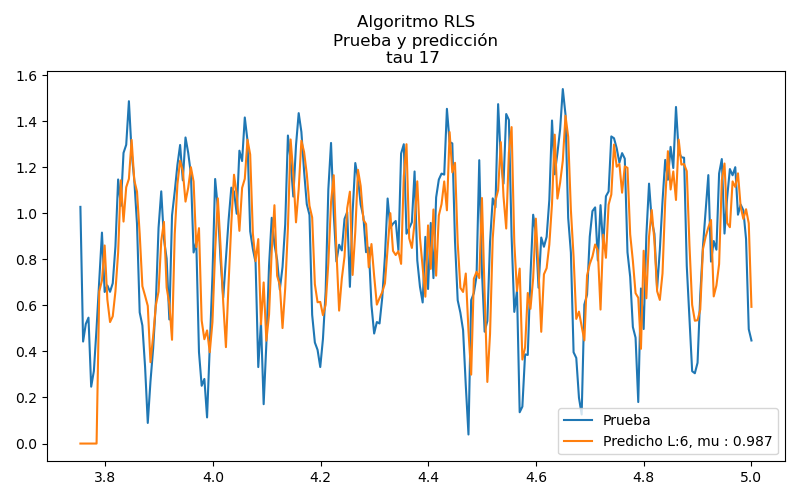

In [971]:
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.plot(t_test, y_test, label='Prueba')
ax.plot(t_test, y_pred_RLS17, label=f'Predicho L:{best_L}, mu : {best_beta:.3f}')

ax.legend()
ax.set_title(f'Algoritmo RLS\nPrueba y predicción\ntau {tau} ');

### Repita el paso anterior para el caso $\tau = 30$

In [973]:
tau = 30
myfilter, best_L, best_beta = train_RLS(tau=tau) 

Best NMSE : 179.8825434201936
L 3 , beta : 0.992000


In [974]:
y_pred_RLS30 = predict_RLS(best_L, y_test, myfilter)

<IPython.core.display.Javascript object>


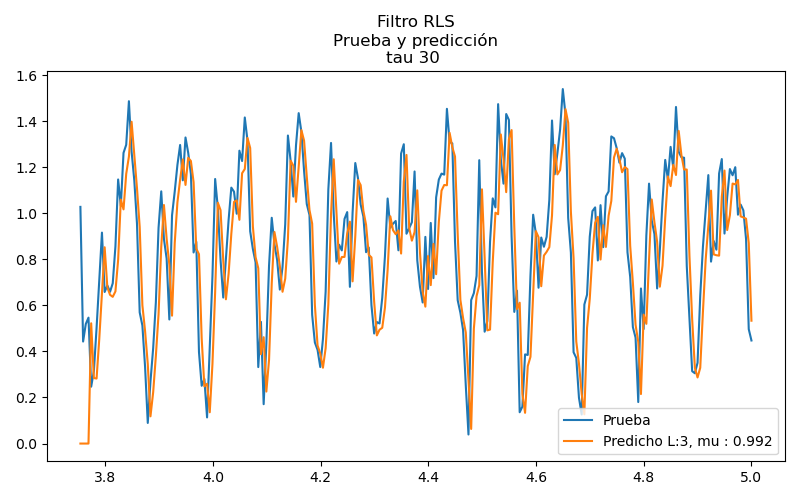

In [975]:
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.plot(t_test, y_test, label='Prueba')
ax.plot(t_test, y_pred_RLS30, label=f'Predicho L:{best_L}, mu : {best_beta:.3f}')

ax.legend()
ax.set_title(f'Filtro RLS\nPrueba y predicción\ntau {tau} ');

### Muestre también los residuos. 


<IPython.core.display.Javascript object>


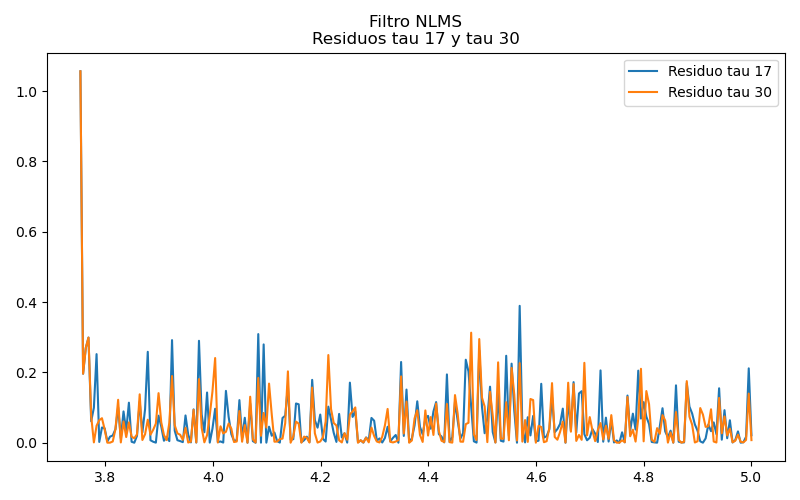

In [977]:
residuo_tau17 = (y_test - y_pred_RLS17)**2 
residuo_tau30 = (y_test - y_pred_RLS30)**2 

fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.plot(t_test, residuo_tau17, label='Residuo tau 17')
ax.plot(t_test, residuo_tau30, label='Residuo tau 30')
ax.set_title(f'Filtro NLMS\nResiduos tau 17 y tau 30');
ax.legend()

####  Discuta y analice sus resultados

Para poder determinar el mejor valor de beta, realizamos un barrido de 100 posibles valores entre 0.9 y 1. Pudimos determinar que para la serie de tiempo con tau 17 el valor de beta es 0.987 y para tau 30 0.992.

Para tau 17 podemos apreciar una clara eliminación de ruido pero ajustandose a la señal de tiempo, lo mismo ocurre en el caso de tau 30, donde existe una clara disminusion, pero esta es menos drástica que en el caso de tau 17.


Al analizar los residuos, podemos ver que no existe una gran difrencia entre los niveles de tau 17 y tau 30, esto puede ser debido a que el algoritmo RLM es capaz de adaptarse de buena manera a ambas series de tiempo.



## (10%) Comparación entre LMS y RLS

1. Compare el mejor predictor LMS y RLS en el conjunto de test en términos de la calidad de la predicción y la velocidad a la que sigue los cambios. Comente y discuta


> Si ambos estan bien calibrados el RLS deberia converger más rapido ver en la grafica de Error cuadratico instantáneo: (señal original limpia - filtrada )^2


### Tau 17

<IPython.core.display.Javascript object>


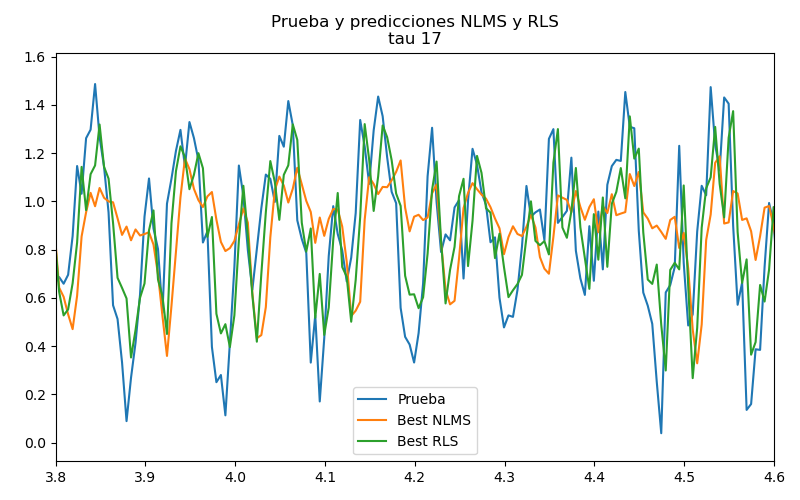

In [978]:
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)

ax.plot(t_test, y_test, label='Prueba')
ax.plot(t_test, y_pred_NLMS17, label=f'Best NLMS')
ax.plot(t_test, y_pred_RLS17, label=f'Best RLS')

ax.legend()
ax.set_xlim([3.8,4.6])
ax.set_title(f'Prueba y predicciones NLMS y RLS\ntau 17');

Podemos apreciar que para tau 17 la señal filtrada con el algotitmo NLMS es bastante más lejana a la serie original con ruido, donde el claro ejemplo de esto es que para poder llegar  desde 1.4 a 0.6 el algoritmo realiza un filtrado mucho más lento que RLS. el cual sigue la forma de gran manera la forma de la serie de tiempo, a diferencia de la filtrada con el algoritmo RLM.

Esto es gracias a la agilidad que tienen el algoritmo RLS, donde en señales como esta, es posible adaptarse a los cambios mucho más velozmente que NLMS

<IPython.core.display.Javascript object>


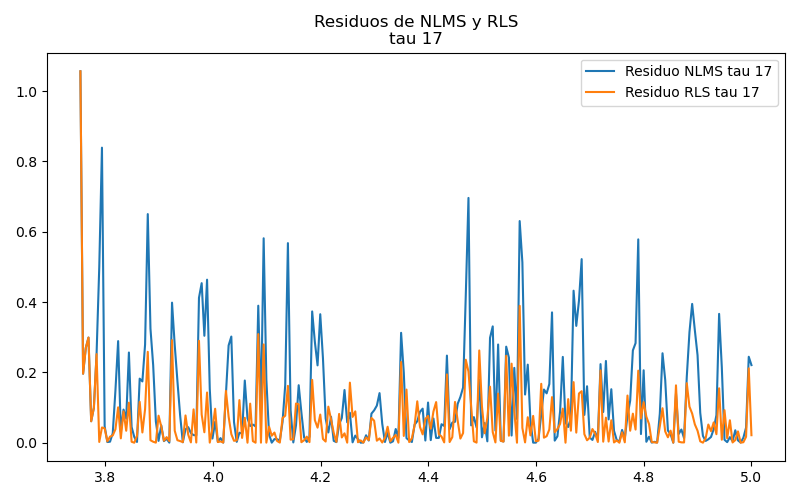

In [980]:
residuo_NLMS17 = (y_test - y_pred_NLMS17)**2 
residuo_RLS17 = (y_test - y_pred_RLS17)**2 

fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.plot(t_test, residuo_NLMS17, label='Residuo NLMS tau 17')
ax.plot(t_test, residuo_RLS17, label='Residuo RLS tau 17')
ax.set_title(f'Residuos de NLMS y RLS\ntau 17');
ax.legend()

Analizando los residuos, podemos ver más claramente como el alogirtrmo RLS es capaz de disminuir la diferencia entre la señal filtrada y la señal originial en una menor cantidad de series de tiempo, ademas tiendo niveles mucho mejores a NLMS

### Tau 30

<IPython.core.display.Javascript object>


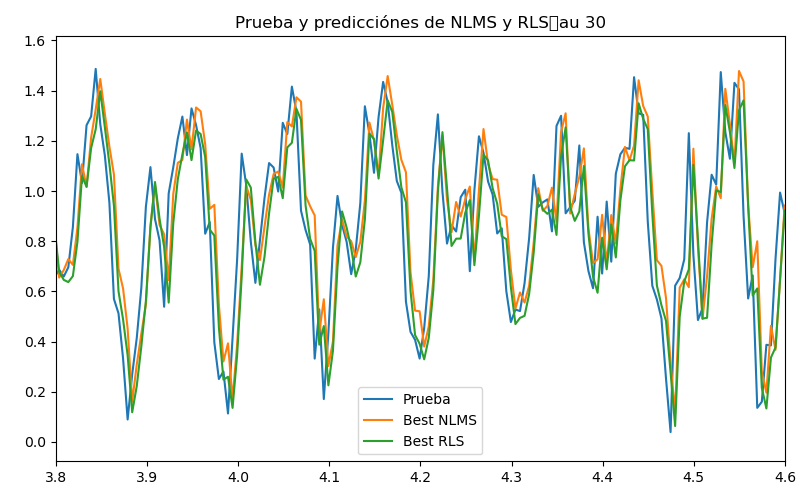

In [981]:
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)

ax.plot(t_test, y_test, label='Prueba')
ax.plot(t_test, y_pred_NLMS30, label=f'Best NLMS')
ax.plot(t_test, y_pred_RLS30, label=f'Best RLS')

ax.legend()
ax.set_xlim([3.8,4.6])
ax.set_title(f'Prueba y predicciónes de NLMS y RLS\tau 30');

PAra tau 30 podemos ver que no es tan notoria la diferencia entre NLMS y RLS, daod que ambos se adaptan bien a los cambios de altura de la serie de tiempo.

<IPython.core.display.Javascript object>


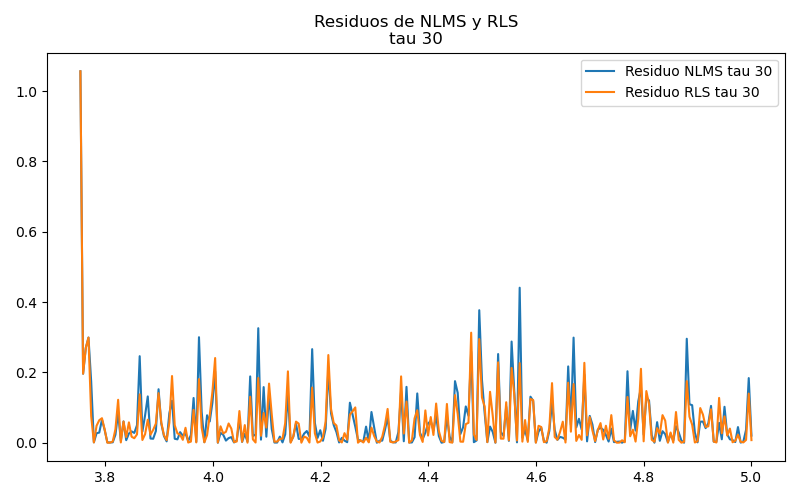

In [982]:
residuo_NLMS30 = (y_test - y_pred_NLMS30)**2 
residuo_RLS30 = (y_test - y_pred_RLS30)**2 

fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.plot(t_test, residuo_NLMS30, label='Residuo NLMS tau 30')
ax.plot(t_test, residuo_RLS30, label='Residuo RLS tau 30')
ax.set_title(f'Residuos de NLMS y RLS\ntau 30');
ax.legend()

Esto queda demostrado al graficar los residuos, donde NLMS y RLS, está mucho más equilibrado en altura.

### Comentarios Finales

Podemos concluir que para tau 17, la elección de un algoritmo RLS es fundamiental, debido a que el algoritmo NLMS no fue capaz de seguir el comportamiento de la serie de tiempo de MAckey-Glass, caso contrario al de RLS el cual cumplió con las espectativas y realizo ajustes de manera casi inmediata. Es posible que se pudiera mejorar el rendimiento de este filto pudiendo realizar un barrido del parametro **lambda**, pero con la implementación realizada se pudo realizar un buen filtrado de la serie de tiempo.

Para tau 30, la situación es un poco distinta, ambos algoritmos fueron capaces de adaptarse mejor a la serie de tiempo, pese a que esta fuera más caotica, es posible que al ser más caotica la trayectoria a trazar fuera más facil de determinar que el caso anteior y debido a esto, ambos algoritmos presentaron un comportamiento correcto. Para nuestro caso, si tuveramos que decidirnos por un algoritmo para tau 30, utilizariamos NLMS, debido a que al ser tan parecida la solución final, el costo computacional que conlleva implementar RLS es un factor a considerar.